# EDA for Togo solar data

Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes 
import os

Setting the country name and creating the data directory 

In [ ]:
COUNTRY_NAME = "togo"  

RAW_DATA_FILE = f'../data/{COUNTRY_NAME}-dapaong_qc.csv' 
CLEANED_DATA_FILE = f'data/{COUNTRY_NAME}_clean.csv'
os.makedirs('data', exist_ok=True)

Loading the data

In [17]:
print(f"--- Starting EDA for {COUNTRY_NAME.upper()} ---")
try:
    df = pd.read_csv(RAW_DATA_FILE)
    print(f"Successfully loaded: {RAW_DATA_FILE}")
except FileNotFoundError:
    print(f"ERROR: Raw data file not found at {RAW_DATA_FILE}. Please check the path and COUNTRY_NAME setting.")
    exit()

--- Starting EDA for TOGO ---
Successfully loaded: ../data/togo-dapaong_qc.csv


Summary Statistics and Missing Values

In [36]:
summary_stats = df.describe()
print("Summary Statistics (Original Data):\n", summary_stats)

missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
print("\nMissing Values (Count):\n", missing_values)
print("\nColumns with >5% Missing Values:\n", missing_percent[missing_percent > 5])


--- Summary Statistics & Missing Values ---
Summary Statistics (Original Data):
                  GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      231.718786     151.258469     116.444352     226.144375   
std       321.691953     250.956962     156.520714     317.346938   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000

Cleaning

Handling Negative Irradiance

In [46]:
irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in irradiance_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"Found {negative_count} negative values in {col}. Clipping to 0.")
            df[col] = np.maximum(0, df[col]) 
    else:
        print(f"Warning: Irradiance column {col} not found in DataFrame.")

Imputation and Z-score outlier Flagging

In [47]:
numeric_cols_for_processing = [
    'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH',
    'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'TModA', 'TModB'
]
actual_numeric_cols = [col for col in numeric_cols_for_processing if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
print("Imputing missing values with median for key numeric columns")
for col in actual_numeric_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        
cols_for_zscore = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
valid_cols_for_zscore = [col for col in cols_for_zscore if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
if valid_cols_for_zscore:
    z_scores_values = stats.zscore(df[valid_cols_for_zscore])
    abs_z_scores = np.abs(z_scores_values)
    
    outlier_flags = (abs_z_scores > 3).any(axis=1)
    df['is_outlier_zscore'] = outlier_flags 
    print(f"Number of rows flagged with Z-score > 3 in any of {valid_cols_for_zscore}: {outlier_flags.sum()}")
else:
    print("No valid columns found for Z-score calculation after initial processing.")
    df['is_outlier_zscore'] = False

df_clean = df.dropna(subset=['Timestamp']).copy()
df_clean.to_csv(CLEANED_DATA_FILE, index=False)
print(f"Cleaned data saved to {CLEANED_DATA_FILE}")
print(f"Shape of cleaned data: {df_clean.shape}")

Imputing missing values with median for key numeric columns
Number of rows flagged with Z-score > 3 in any of ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']: 9257
Cleaned data saved to data/togo_clean.csv
Shape of cleaned data: (525600, 20)


Time series Analysis

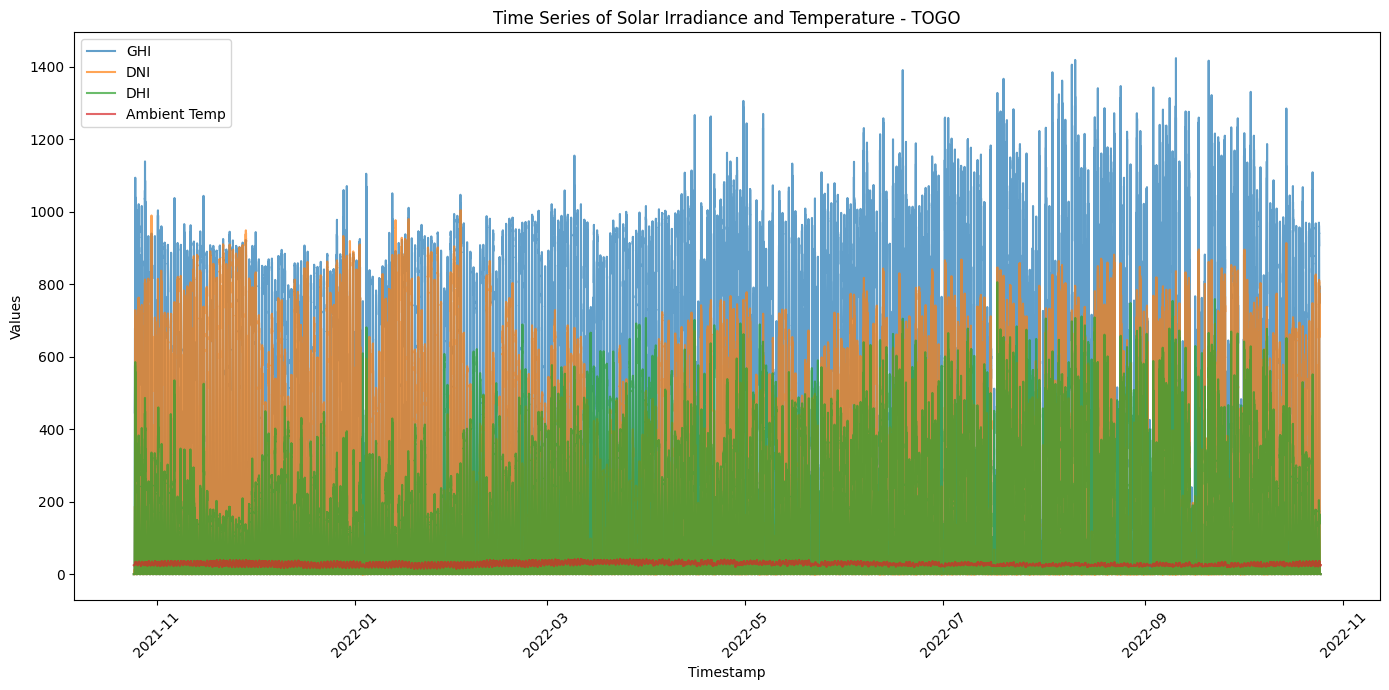

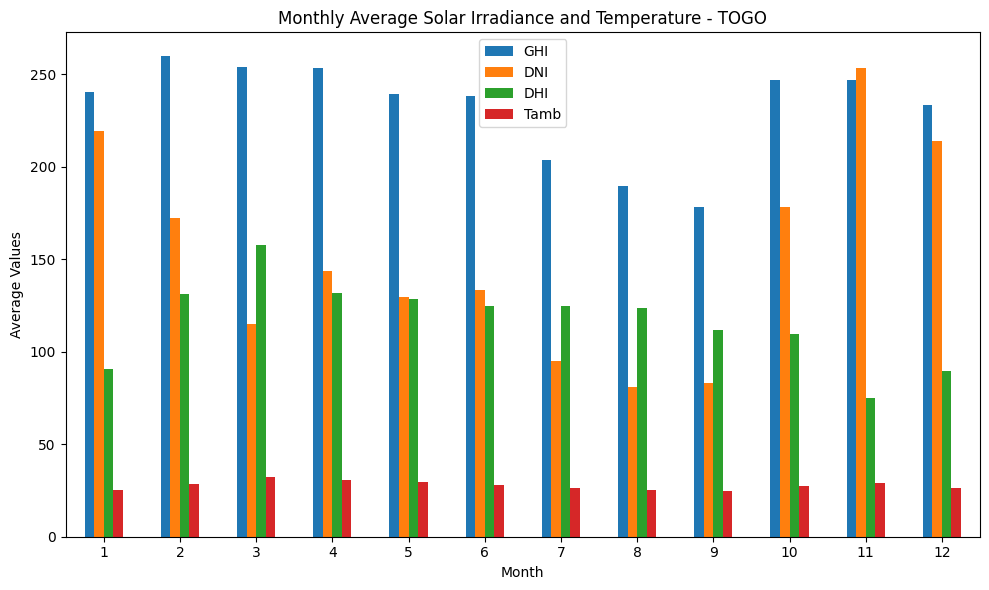

In [48]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

plt.figure(figsize=(14, 7))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI', alpha=0.7)
plt.plot(df_clean['Timestamp'], df_clean['DNI'], label='DNI', alpha=0.7)
plt.plot(df_clean['Timestamp'], df_clean['DHI'], label='DHI', alpha=0.7)
if 'Tamb' in df_clean.columns:
    plt.plot(df_clean['Timestamp'], df_clean['Tamb'], label='Ambient Temp', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title(f'Time Series of Solar Irradiance and Temperature - {COUNTRY_NAME.upper()}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly averages
df_clean['Month'] = df_clean['Timestamp'].dt.month
time_series_cols_for_monthly_avg = ['GHI', 'DNI', 'DHI']
if 'Tamb' in df_clean.columns:
    time_series_cols_for_monthly_avg.append('Tamb')

monthly_avg = df_clean.groupby('Month')[time_series_cols_for_monthly_avg].mean()
monthly_avg.plot(kind='bar', figsize=(10, 6))
plt.title(f'Monthly Average Solar Irradiance and Temperature - {COUNTRY_NAME.upper()}')
plt.xlabel('Month')
plt.ylabel('Average Values')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Cleaning Impact Analysis

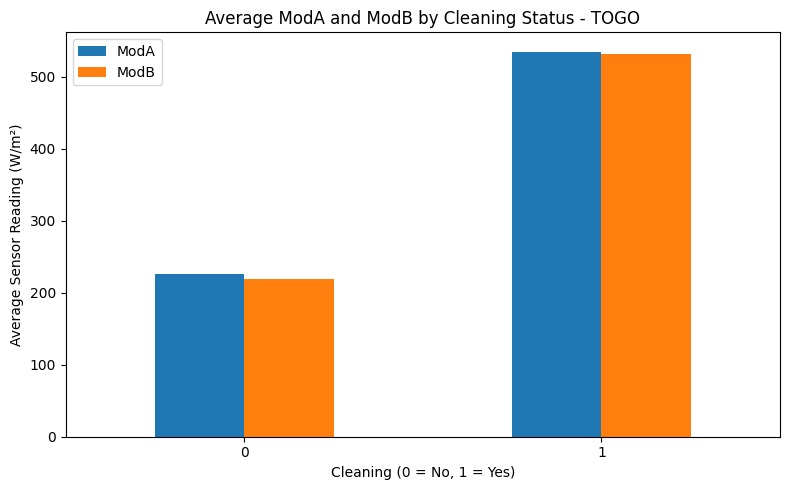

In [49]:
if 'Cleaning' in df_clean.columns and 'ModA' in df_clean.columns and 'ModB' in df_clean.columns:
    
    if df_clean['Cleaning'].nunique() <= 2 :
        cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
        cleaning_impact.plot(kind='bar', figsize=(8, 5))
        plt.title(f'Average ModA and ModB by Cleaning Status - {COUNTRY_NAME.upper()}')
        plt.xlabel('Cleaning (0 = No, 1 = Yes)')
        plt.ylabel('Average Sensor Reading (W/m²)')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Cleaning column has too many unique values or is not binary. Skipping plot.")
else:
    print("Skipping Cleaning Impact: 'Cleaning', 'ModA', or 'ModB' column not found or not suitable.")

Cleaning and Relationship Analysis

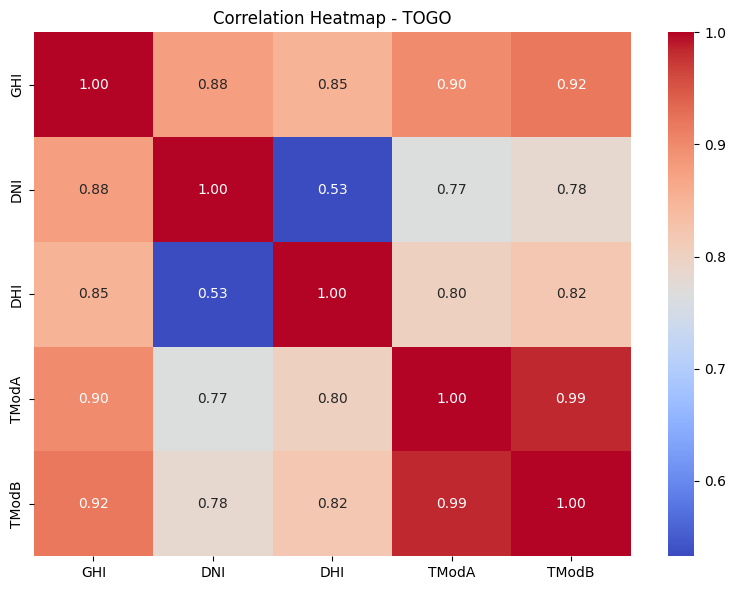

Generating scatter plots...


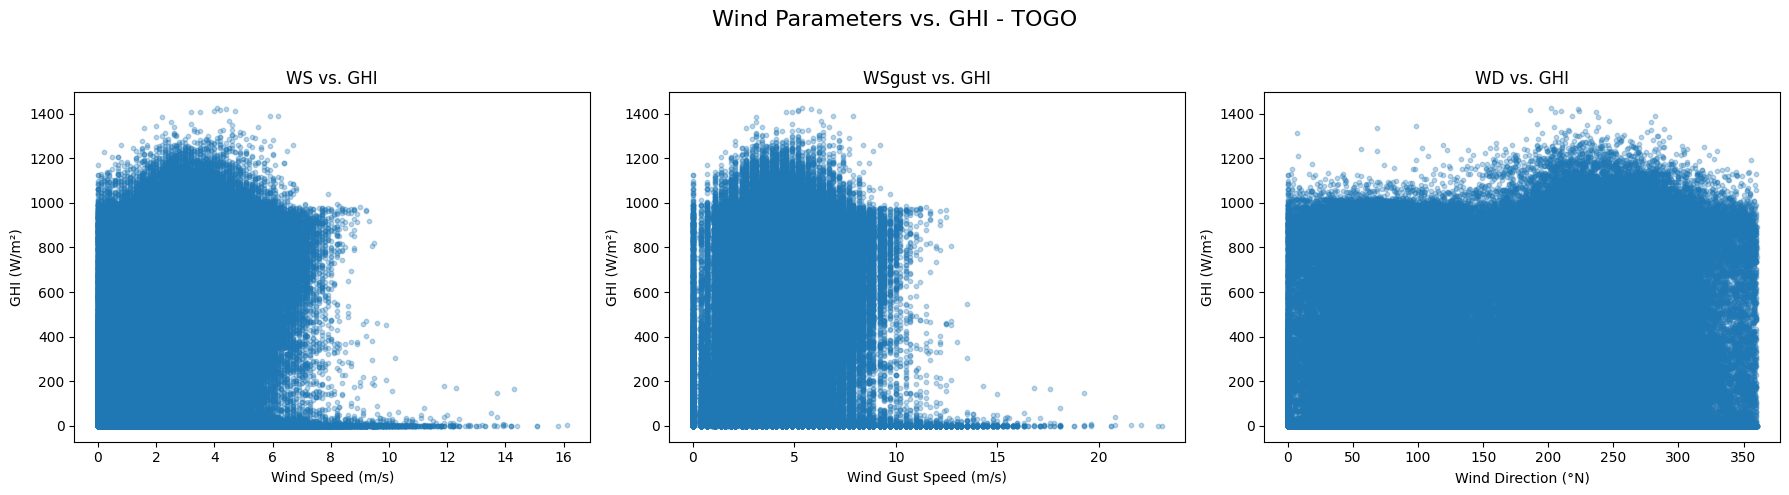

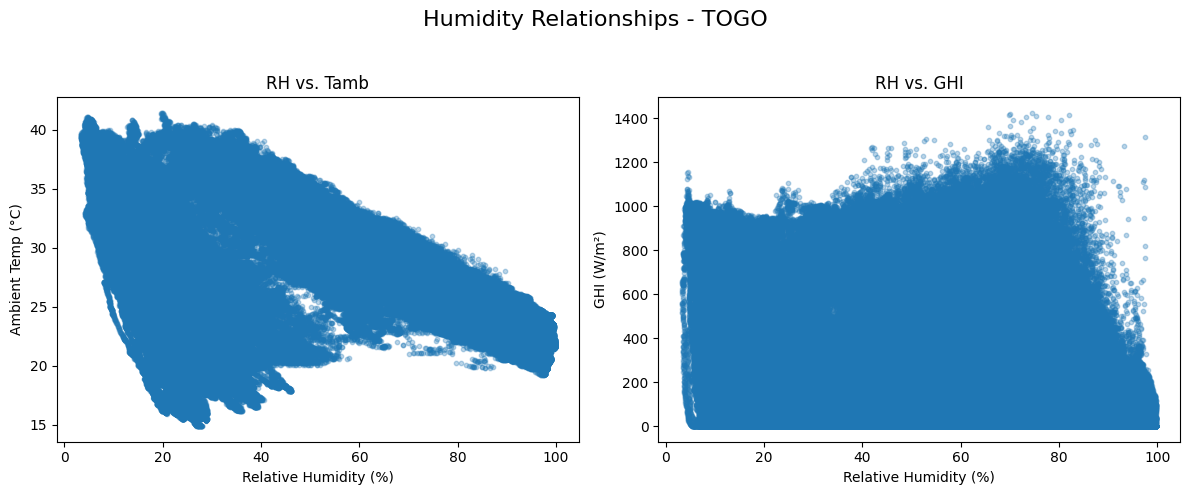

In [52]:
corr_cols = ['GHI', 'DNI', 'DHI']
if 'TModA' in df_clean.columns: corr_cols.append('TModA')
if 'TModB' in df_clean.columns: corr_cols.append('TModB')

corr_matrix = df_clean[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap - {COUNTRY_NAME.upper()}')
plt.tight_layout()
plt.show()

print("Generating scatter plots...")
plt.figure(figsize=(18, 5)) 

plt.subplot(1, 3, 1)
if 'WS' in df_clean.columns and 'GHI' in df_clean.columns:
    plt.scatter(df_clean['WS'], df_clean['GHI'], alpha=0.3, s=10)
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('GHI (W/m²)')
    plt.title('WS vs. GHI')
else:
    plt.text(0.5, 0.5, 'WS or GHI not available', ha='center', va='center')


plt.subplot(1, 3, 2)
if 'WSgust' in df_clean.columns and 'GHI' in df_clean.columns:
    plt.scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.3, s=10)
    plt.xlabel('Wind Gust Speed (m/s)')
    plt.ylabel('GHI (W/m²)')
    plt.title('WSgust vs. GHI')
else:
    plt.text(0.5, 0.5, 'WSgust or GHI not available', ha='center', va='center')


plt.subplot(1, 3, 3)
if 'WD' in df_clean.columns and 'GHI' in df_clean.columns:
    plt.scatter(df_clean['WD'], df_clean['GHI'], alpha=0.3, s=10)
    plt.xlabel('Wind Direction (°N)')
    plt.ylabel('GHI (W/m²)')
    plt.title('WD vs. GHI')
else:
    plt.text(0.5, 0.5, 'WD or GHI not available', ha='center', va='center')

plt.suptitle(f'Wind Parameters vs. GHI - {COUNTRY_NAME.upper()}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
if 'RH' in df_clean.columns and 'Tamb' in df_clean.columns:
    plt.scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.3, s=10)
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Ambient Temp (°C)')
    plt.title('RH vs. Tamb')
else:
    plt.text(0.5, 0.5, 'RH or Tamb not available', ha='center', va='center')

plt.subplot(1, 2, 2)
if 'RH' in df_clean.columns and 'GHI' in df_clean.columns:
    plt.scatter(df_clean['RH'], df_clean['GHI'], alpha=0.3, s=10)
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('GHI (W/m²)')
    plt.title('RH vs. GHI')
else:
    plt.text(0.5, 0.5, 'RH or GHI not available', ha='center', va='center')

plt.suptitle(f'Humidity Relationships - {COUNTRY_NAME.upper()}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Wind Distribution Analysis

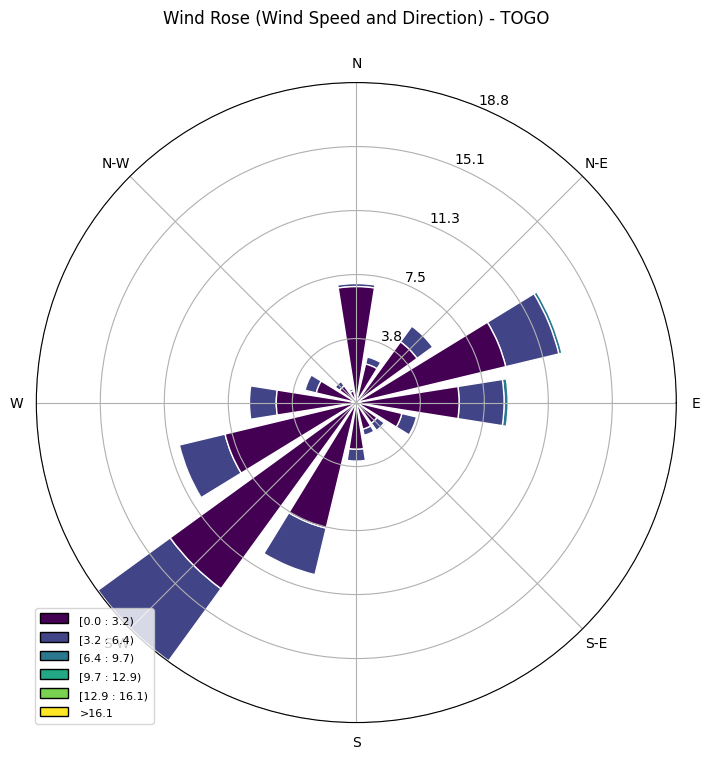

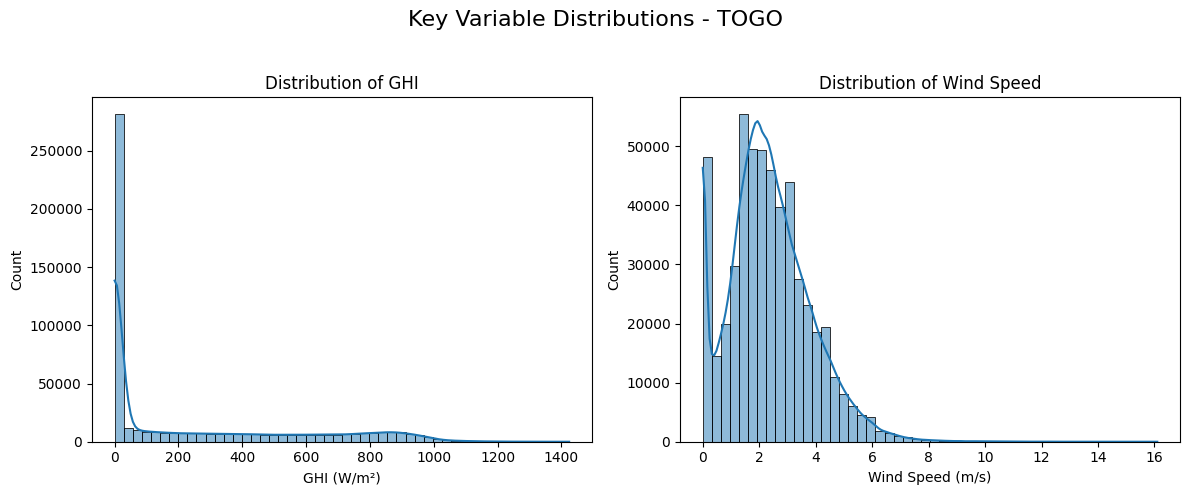

In [54]:
if 'WD' in df_clean.columns and 'WS' in df_clean.columns:
    wind_data_for_rose = df_clean[['WD', 'WS']].dropna()
    if not wind_data_for_rose.empty:
        try:
            fig = plt.figure(figsize=(8, 8))
            ax = WindroseAxes.from_ax(fig=fig)
            ax.bar(wind_data_for_rose['WD'], wind_data_for_rose['WS'], normed=True, opening=0.8, edgecolor='white')
            ax.set_legend()
            plt.title(f'Wind Rose (Wind Speed and Direction) - {COUNTRY_NAME.upper()}', y=1.08)
            plt.show()
        except Exception as e:
            print(f"Could not generate Wind Rose: {e}")
    else:
        print("No valid data for Wind Rose after dropping NaNs.")
else:
    print("Skipping Wind Rose: 'WD' or 'WS' column not found.")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
if 'GHI' in df_clean.columns:
    sns.histplot(df_clean['GHI'].dropna(), bins=50, kde=True) 
    plt.title('Distribution of GHI')
    plt.xlabel('GHI (W/m²)')
else:
    plt.text(0.5, 0.5, 'GHI not available', ha='center', va='center')


plt.subplot(1, 2, 2)
if 'WS' in df_clean.columns:
    sns.histplot(df_clean['WS'].dropna(), bins=50, kde=True)
    plt.title('Distribution of Wind Speed')
    plt.xlabel('Wind Speed (m/s)')
else:
    plt.text(0.5, 0.5, 'WS not available', ha='center', va='center')

plt.suptitle(f'Key Variable Distributions - {COUNTRY_NAME.upper()}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Temprature and Humidity Influence Analysis 

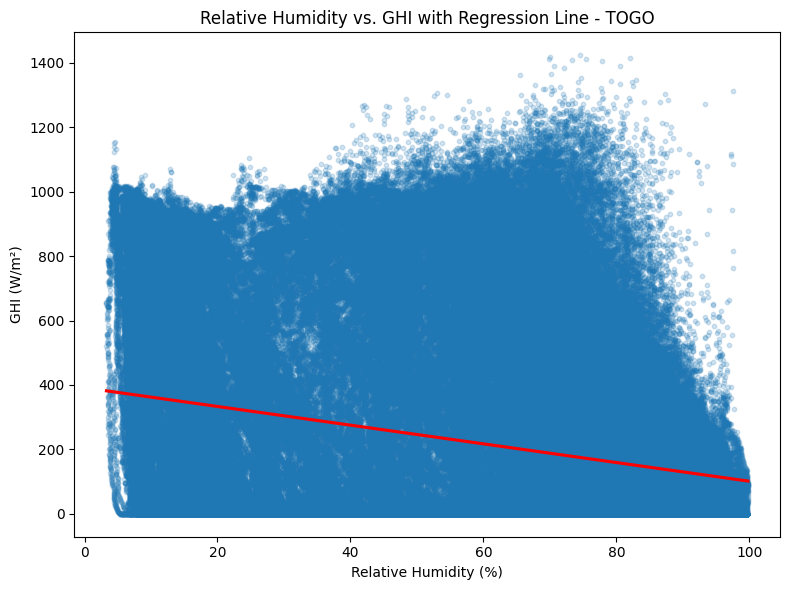

In [56]:
if 'RH' in df_clean.columns and 'GHI' in df_clean.columns:
    plt.figure(figsize=(8, 6))
    sns.regplot(x='RH', y='GHI', data=df_clean, scatter_kws={'alpha':0.2, 's':10}, line_kws={'color':'red'})
    plt.title(f'Relative Humidity vs. GHI with Regression Line - {COUNTRY_NAME.upper()}')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('GHI (W/m²)')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping RH vs GHI regplot: 'RH' or 'GHI' column not found.")

Buble Chart -> GHI vs Tamb 


--- Bubble Chart: GHI vs. Tamb (Size by RH) ---


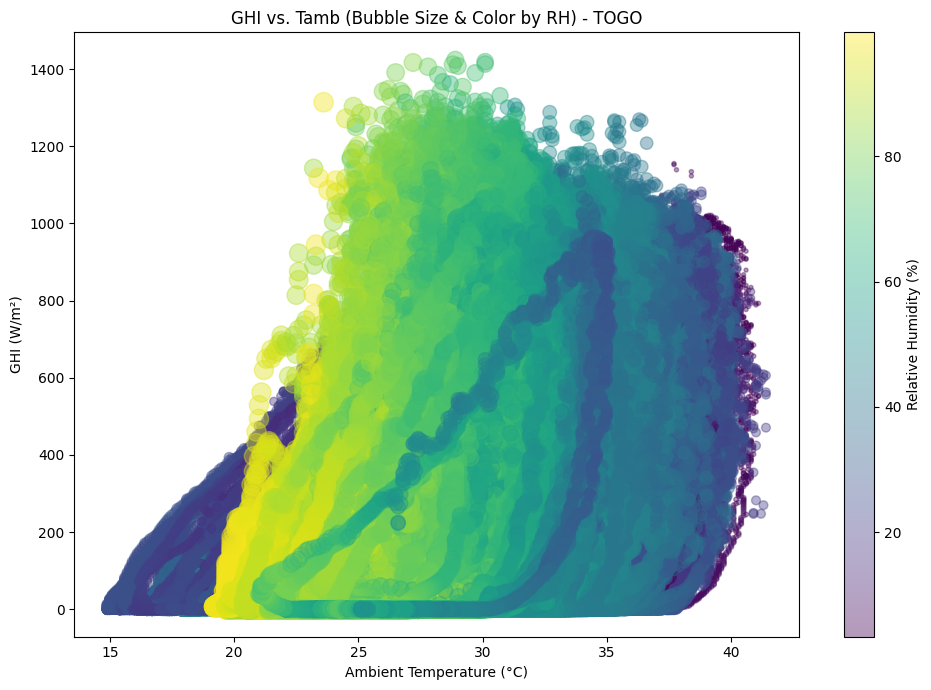


--- EDA for TOGO Complete ---


In [32]:
if 'Tamb' in df_clean.columns and 'GHI' in df_clean.columns and 'RH' in df_clean.columns:
    rh_normalized = df_clean['RH'].dropna()
    if not rh_normalized.empty:
        bubble_sizes = (rh_normalized / rh_normalized.max()) * 200 + 10 
        temp_df_for_bubble = df_clean[['Tamb', 'GHI', 'RH']].dropna()
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(temp_df_for_bubble['Tamb'], temp_df_for_bubble['GHI'],
                              s=temp_df_for_bubble['RH'] * 2, 
                              alpha=0.4, c=temp_df_for_bubble['RH'], cmap='viridis')
        plt.xlabel('Ambient Temperature (°C)')
        plt.ylabel('GHI (W/m²)')
        plt.title(f'GHI vs. Tamb (Bubble Size & Color by RH) - {COUNTRY_NAME.upper()}')
        cbar = plt.colorbar(scatter, label='Relative Humidity (%)')
        plt.tight_layout()
        plt.show()
    else:
        print("RH data is empty after dropping NaNs, cannot create bubble chart.")
else:
    print("Skipping Bubble Chart: 'Tamb', 'GHI', or 'RH' column not found.")

print(f"\n--- EDA for {COUNTRY_NAME.upper()} Complete ---")